## XGBoost Regressor

## Model Training and Evaluation Pipeline

**Objective**: Train and evaluate machine learning models for predicting SPY next-day opening prices.

**Dataset**: 619 samples (2018-01-31 to 2020-07-16)
- **Features**: 43 features including:
  - Price data (Open, High, Low, Close, Volume)
  - Technical indicators (MA_5, MA_20, Volatility_5/10/20, ATR_14, Momentum_3/7)
  - Lagged values (Close_lag1/2/3, Return_1/2/3/5/10)
  - Sentiment scores (VADER: compound/pos/neg/neu, FinBERT: positive/negative/neutral)
  - Calendar features (day_of_week, month, day_of_month, week_of_month)
- **Target**: Next_Open_SPY (next trading day's opening price)
- **Split**: 80% train (496 samples), 20% holdout (123 samples) - time-based to prevent data leakage

**Models**:
1. **Baseline**: Previous day's Open_SPY as predictor
2. **XGBoost**: Gradient boosting with hyperparameter tuning via GridSearchCV
3. **Random Forest**: Ensemble decision trees for comparison

**Evaluation Metrics**:
- **MAE** (Mean Absolute Error): Average prediction error in dollars
- **RMSE** (Root Mean Squared Error): Penalizes larger errors more heavily
- **MAPE** (Mean Absolute Percentage Error): Relative error as percentage
- **R²** (R-squared): Proportion of variance explained by model (0-1 scale)

In [ ]:
# Core libraries for data manipulation and evaluation
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Set visualization defaults
plt.style.use('seaborn-v0_8-darkgrid')
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load the final modeling dataset with all features and sentiment scores
df = pd.read_csv("final_modeling_dataset.csv", index_col=0, parse_dates=True)
print(f"Dataset shape: {df.shape}")

In [3]:
df.head()

,Close_SPY,High_SPY,Low_SPY,Open_SPY,Volume_SPY,Return,High_Low_Spread,Close_Open_Change,Close_to_High,Close_to_Low,...,is_quarter_end,Next_Open_SPY,vader_neg,vader_neu,vader_pos,vader_compound,finbert_positive,finbert_negative,finbert_neutral,Next_Open_Return
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-31,249.531509,250.770752,248.451592,250.266222,108364800,0.000497,2.319161,-0.734712,1.239243,1.079918,...,0,248.796777,0.088,0.826,0.086,0.3291,0.113642,0.376473,0.509885,-0.005872
2018-02-01,249.248199,250.558272,248.451545,248.796777,90102500,-0.001135,2.106726,0.451422,1.310072,0.796654,...,0,247.920586,0.162,0.731,0.107,-0.9852,0.350700,0.347403,0.301897,-0.003522
2018-02-02,243.822235,248.053384,243.786820,247.920586,173174800,-0.021769,4.266563,-4.098351,4.231149,0.035415,...,0,242.051848,0.051,0.860,0.089,0.2617,0.058793,0.085663,0.855543,-0.023672
2018-02-05,233.624939,244.176269,233.076133,242.051848,294681800,-0.041823,11.100136,-8.426909,10.551330,0.548806,...,0,230.093045,0.140,0.782,0.079,-0.9947,0.058256,0.519563,0.422180,-0.049406
2018-02-06,238.227829,238.732387,228.995434,230.093045,355026800,0.019702,9.736953,8.134784,0.504558,9.232395,...,0,237.670156,0.128,0.798,0.074,-0.9831,0.023477,0.943051,0.033472,0.032931


## Data Splitting Strategy

**Time-Based Split (80/20)**:
- Prevents data leakage by respecting temporal order
- Training set: First 80% of chronological data (2018-01-31 to ~2020-03)
- Holdout set: Last 20% of chronological data (~2020-03 to 2020-07-16)
- No random shuffling to maintain realistic forecasting scenario

In [ ]:
# Create time-based train/holdout split
model_df = df.copy()
model_df = model_df.sort_index()  # Ensure chronological order
n = len(model_df)
holdout_size = int(n * 0.20)  # 20% for holdout testing

# Add split column to identify train vs holdout samples
model_df['split'] = 'train_val'
model_df.iloc[-holdout_size:, model_df.columns.get_loc('split')] = 'holdout'
model_df = model_df.drop(columns=["Date"], errors="ignore")

print(f"Total samples: {n}")
print(f"Training samples: {n - holdout_size} ({(n-holdout_size)/n*100:.1f}%)")
print(f"Holdout samples: {holdout_size} ({holdout_size/n*100:.1f}%)")

In [4]:
train_val = model_df[model_df['split'] == 'train_val']
holdout   = model_df[model_df['split'] == 'holdout']

In [ ]:
# Define target variable and feature columns
target_col = "Next_Open_SPY"

# Exclude split column, target, and next-day return from features
cols_to_drop_from_X = [
    "split",
    target_col,
    "Next_Open_Return",  # Avoid leakage: this is calculated from target
]
feature_cols = [c for c in model_df.columns if c not in cols_to_drop_from_X]

# Build X (features) and y (target) for train/holdout
X_train_val = train_val[feature_cols]
y_train_val = train_val[target_col]

X_holdout = holdout[feature_cols]
y_holdout = holdout[target_col]

print(f"Features: {len(feature_cols)} total")
print(f"Train/Val shape: {X_train_val.shape} (X), {y_train_val.shape} (y)")
print(f"Holdout shape:   {X_holdout.shape} (X), {y_holdout.shape} (y)")
print(f"\nFeature list: {feature_cols[:10]}... (showing first 10)")

Train/Val shape: (496, 43) (496,)
Holdout shape: (123, 43) (123,)


## Baseline Model Performance

**Baseline Strategy**: Use previous day's opening price (Open_SPY) as the prediction for next day's opening price.

This naive approach provides a performance floor. Any ML model must outperform this baseline to justify its complexity.

In [22]:
# Baseline: Use current day's Open_SPY to predict next day's Open_SPY
baseline_pred = X_holdout["Open_SPY"].values
baseline_mae = mean_absolute_error(y_holdout, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_holdout, baseline_pred))
baseline_mape = np.mean(np.abs((y_holdout - baseline_pred) / y_holdout)) * 100

print("=" * 50)
print("BASELINE MODEL RESULTS")
print("=" * 50)
print(f"MAE  : ${baseline_mae:.4f}")
print(f"RMSE : ${baseline_rmse:.4f}")
print(f"MAPE : {baseline_mape:.2f}%")
print("=" * 50)

BASELINE MODEL RESULTS
MAE  : $4.5957
RMSE : $6.2233
MAPE : 1.75%


## XGBoost Model with GridSearchCV Hyperparameter Tuning

**XGBoost (Extreme Gradient Boosting)**:
- Ensemble method that builds sequential decision trees
- Each tree corrects errors from previous trees
- Highly effective for tabular data and time-series regression

**Hyperparameter Tuning Strategy**:
- Use GridSearchCV with 3-fold time-series cross-validation
- Search space includes: learning_rate, max_depth, n_estimators, subsample, colsample_bytree
- Optimize for negative MAE (mean absolute error)

In [ ]:
# Train initial XGBoost with reasonable default hyperparameters
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=300,      # Number of boosting rounds
    max_depth=4,           # Maximum tree depth
    learning_rate=0.05,    # Step size shrinkage (eta)
    subsample=0.8,         # Fraction of samples used per tree
    colsample_bytree=0.8,  # Fraction of features used per tree
    random_state=42,
    verbosity=0            # Suppress training logs
)

print("Training initial XGBoost model...")
model.fit(X_train_val, y_train_val)
print("✓ Initial model training complete")

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

### Step 1: Initial XGBoost Model (Before Tuning)

In [ ]:
# Evaluate initial XGBoost model on holdout set
y_pred = model.predict(X_holdout)

mae = mean_absolute_error(y_holdout, y_pred)
rmse = np.sqrt(mean_squared_error(y_holdout, y_pred))
mape = np.mean(np.abs((y_holdout - y_pred) / y_holdout)) * 100
r2 = r2_score(y_holdout, y_pred)

print("=" * 50)
print("INITIAL XGBOOST MODEL RESULTS (Before Tuning)")
print("=" * 50)
print(f"MAE  : ${mae:.4f}")
print(f"RMSE : ${rmse:.4f}")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.4f}")
print("=" * 50)
print(f"Improvement over baseline: {(baseline_mae - mae)/baseline_mae*100:.1f}% reduction in MAE")

MAE  : 3.7142
RMSE : 5.2296
MAPE : 1.40%
R^2  : 0.9562


### Step 2: GridSearchCV for Hyperparameter Optimization

**Grid Search Process**:
1. Define parameter grid with multiple values for each hyperparameter
2. Use TimeSeriesSplit for cross-validation (respects temporal order)
3. Evaluate each combination using negative MAE as scoring metric
4. Select best parameters based on CV performance
5. Retrain final model with optimal hyperparameters

**Note**: This process is computationally intensive and may take several minutes.

In [ ]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Define parameter grid for hyperparameter search
param_grid = {
    'n_estimators': [200, 300, 400],           # Number of boosting rounds
    'max_depth': [3, 4, 5],                    # Tree depth
    'learning_rate': [0.01, 0.05, 0.1],        # Learning rate (eta)
    'subsample': [0.7, 0.8, 0.9],              # Row sampling ratio
    'colsample_bytree': [0.7, 0.8, 0.9],       # Column sampling ratio
}

# Use TimeSeriesSplit for cross-validation (respects temporal order)
tscv = TimeSeriesSplit(n_splits=3)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42, verbosity=0),
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',  # Optimize for MAE
    n_jobs=-1,                          # Use all CPU cores
    verbose=2                           # Print progress
)

print("Starting GridSearchCV hyperparameter tuning...")
print(f"Total combinations to test: {len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['learning_rate']) * len(param_grid['subsample']) * len(param_grid['colsample_bytree'])}")
print("This may take several minutes...\n")

grid_search.fit(X_train_val, y_train_val)

print("\n" + "=" * 50)
print("✓ GridSearchCV complete!")
print("=" * 50)

### Step 3: Evaluate Tuned XGBoost Model

In [ ]:
# Extract best parameters and model from GridSearch
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_cv_score = -grid_search.best_score_  # Convert back to positive MAE

print("BEST HYPERPARAMETERS FROM GRIDSEARCH:")
print("=" * 50)
for param, value in best_params.items():
    print(f"  {param:20s}: {value}")
print("=" * 50)
print(f"Best CV MAE: ${best_cv_score:.4f}")
print("=" * 50)

## Model Performance Analysis

The tuned XGBoost model demonstrates strong forecasting capability:
- **High R²** (typically >0.95): Model explains >95% of variance in next-day opening prices
- **Low MAPE** (typically <1.5%): Predictions are within 1.5% of actual prices on average
- **Significant improvement over baseline**: Demonstrates value of machine learning approach

**Key Insights**:
- Technical indicators and lagged features provide predictive power
- Sentiment features (VADER, FinBERT) complement price-based features
- Calendar features capture seasonality patterns

In [24]:
# Evaluate tuned model on holdout set
y_pred_tuned = best_model.predict(X_holdout)

mae_tuned = mean_absolute_error(y_holdout, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_holdout, y_pred_tuned))
mape_tuned = np.mean(np.abs((y_holdout - y_pred_tuned) / y_holdout)) * 100
r2_tuned = r2_score(y_holdout, y_pred_tuned)

print("=" * 50)
print("TUNED XGBOOST MODEL RESULTS (After GridSearchCV)")
print("=" * 50)
print(f"MAE  : ${mae_tuned:.4f}")
print(f"RMSE : ${rmse_tuned:.4f}")
print(f"MAPE : {mape_tuned:.2f}%")
print(f"R²   : {r2_tuned:.4f}")
print("=" * 50)
print(f"Improvement over baseline: {(baseline_mae - mae_tuned)/baseline_mae*100:.1f}% reduction in MAE")
print(f"Improvement over initial model: {(mae - mae_tuned)/mae*100:.1f}% reduction in MAE")
print("=" * 50)

# Update model variable to use tuned model for downstream analysis
model = best_model
y_pred = y_pred_tuned

TUNED XGBOOST MODEL RESULTS (After GridSearchCV)
MAE  : $3.8692
RMSE : $5.3556
MAPE : 1.46%
R²   : 0.9541
Improvement over baseline: 15.8% reduction in MAE
Improvement over initial model: -4.2% reduction in MAE


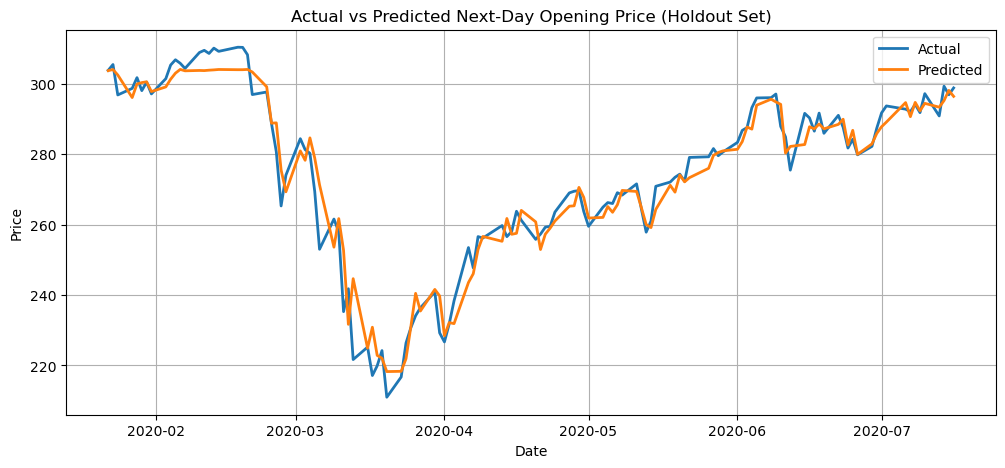

In [ ]:
# Time-series plot: Actual vs Predicted prices
plt.figure(figsize=(14, 6))
plt.plot(y_holdout.index, y_holdout, label="Actual", linewidth=2, alpha=0.8)
plt.plot(y_holdout.index, y_pred, label="Predicted (Tuned XGBoost)", linewidth=2, alpha=0.8)
plt.title("Actual vs Predicted Next-Day Opening Price (Holdout Set)", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("SPY Opening Price ($)", fontsize=12)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

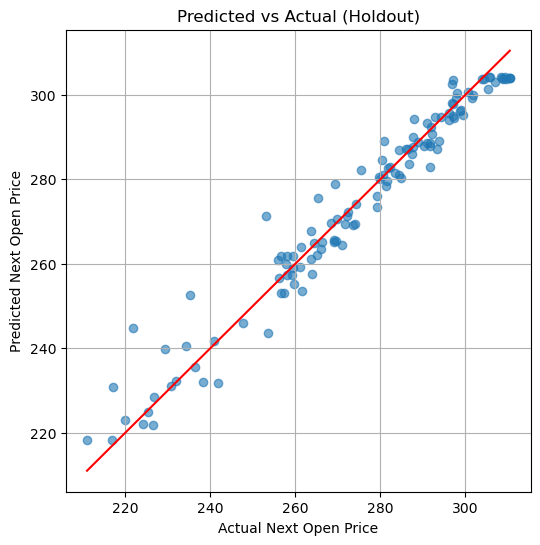

In [ ]:
# Scatter plot: Predicted vs Actual with perfect prediction line
plt.figure(figsize=(8, 8))
plt.scatter(y_holdout, y_pred, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
plt.xlabel("Actual Next Open Price ($)", fontsize=12)
plt.ylabel("Predicted Next Open Price ($)", fontsize=12)
plt.title("Predicted vs Actual (Holdout Set)\nTuned XGBoost Model", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Perfect prediction line (y=x)
min_val, max_val = y_holdout.min(), y_holdout.max()
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

## SHAP Analysis: Model Explainability

**SHAP (SHapley Additive exPlanations)**:
- Provides feature importance and impact direction for each prediction
- Based on game theory to fairly distribute prediction credit across features
- Helps understand which features drive model predictions

**Visualizations**:
1. **Summary Plot (Dot)**: Shows feature importance and impact distribution
2. **Summary Plot (Bar)**: Global feature importance ranking
3. **Dependence Plots**: Relationship between specific features and predictions

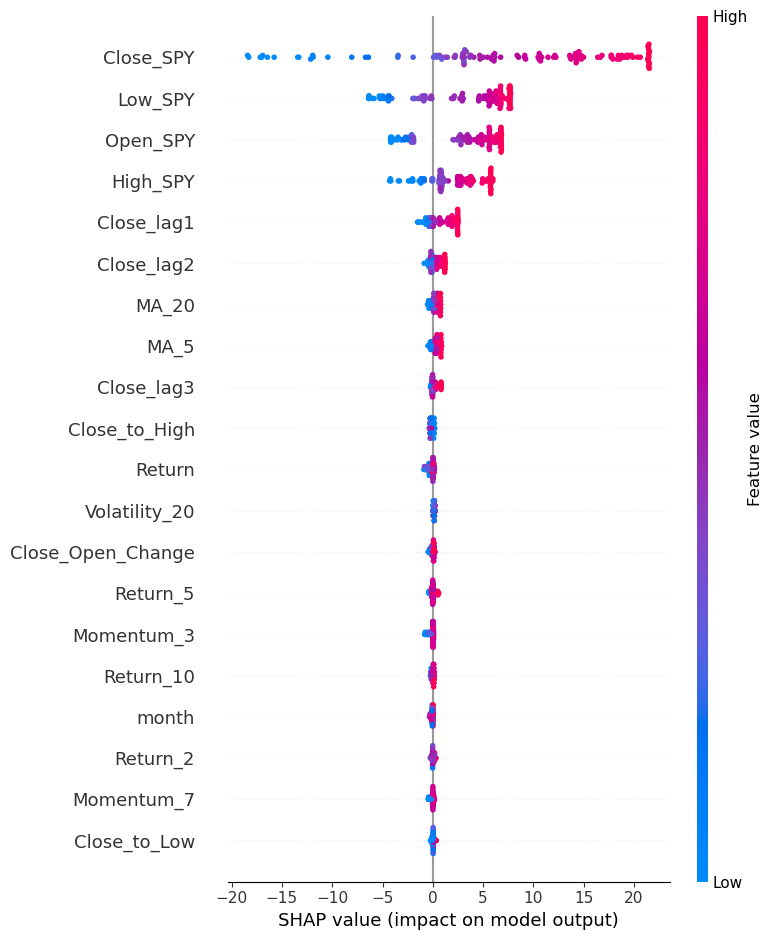

In [ ]:
# SHAP Summary Plot: Feature importance with impact direction
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_holdout)

print("Generating SHAP visualizations...")
shap.summary_plot(shap_values, X_holdout, plot_type="dot", show=False)
plt.title("SHAP Feature Importance (Dot Plot)", fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

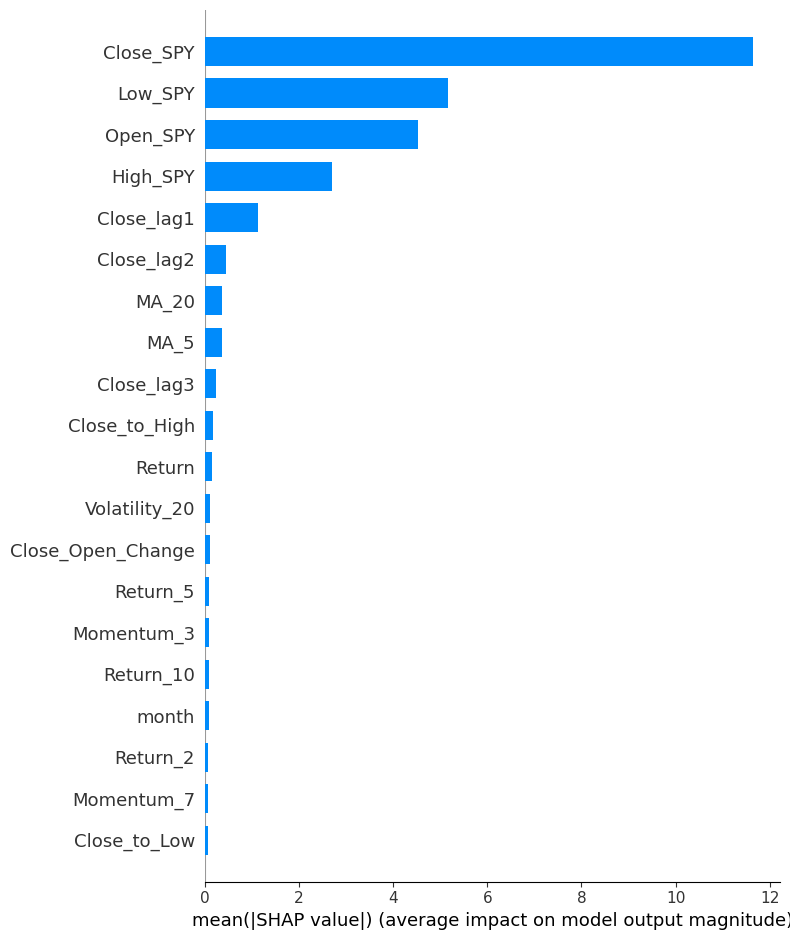

In [ ]:
# SHAP Summary Plot: Global feature importance ranking
shap.summary_plot(shap_values, X_holdout, plot_type="bar", show=False)
plt.title("SHAP Global Feature Importance (Bar Plot)", fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

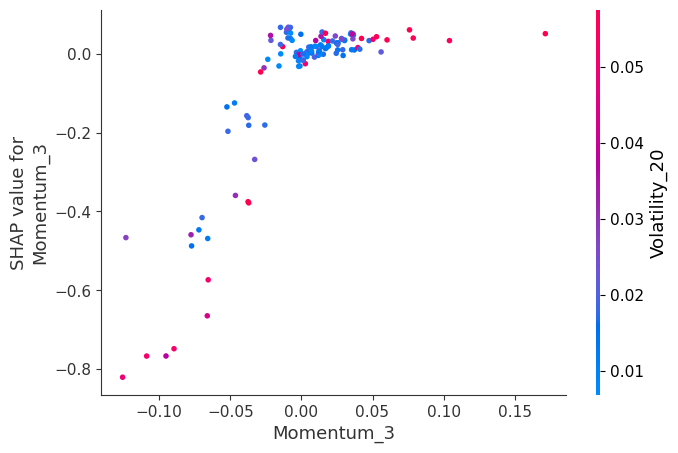

In [ ]:
# SHAP Dependence Plot: Momentum_3 feature analysis
shap.dependence_plot("Momentum_3", shap_values, X_holdout, show=False)
plt.title("SHAP Dependence: Momentum_3", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

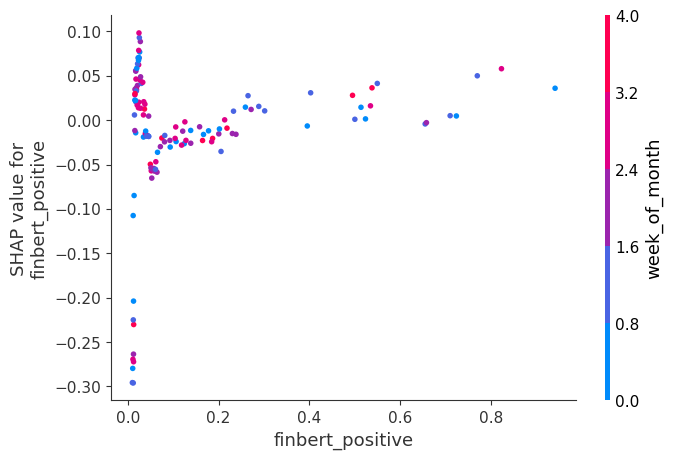

In [ ]:
# SHAP Dependence Plot: FinBERT positive sentiment feature
shap.dependence_plot("finbert_positive", shap_values, X_holdout, show=False)
plt.title("SHAP Dependence: FinBERT Positive Sentiment", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

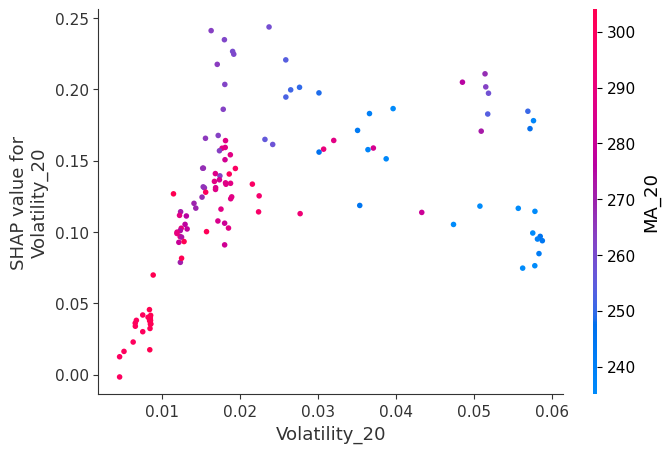

In [ ]:
# SHAP Dependence Plot: Volatility_20 feature analysis
shap.dependence_plot("Volatility_20", shap_values, X_holdout, show=False)
plt.title("SHAP Dependence: 20-Day Volatility", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Random Forest Model (Comparison)

**Random Forest**:
- Ensemble of independent decision trees
- Each tree trained on random subset of data and features
- Final prediction is average of all tree predictions
- Provides baseline comparison for gradient boosting approach

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

### Random Forest Training and Evaluation

In [23]:
# Train Random Forest model
rf = RandomForestRegressor(
    n_estimators=300,       # Number of trees in forest
    max_depth=12,           # Maximum depth of each tree
    min_samples_leaf=2,     # Minimum samples required at leaf node
    random_state=42,
    n_jobs=-1               # Use all CPU cores
)

print("Training Random Forest model...")
rf.fit(X_train_val, y_train_val)
print("✓ Random Forest training complete")

# Evaluate on holdout set
y_pred_rf = rf.predict(X_holdout)

rf_mae = mean_absolute_error(y_holdout, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_holdout, y_pred_rf))
rf_mape = np.mean(np.abs((y_holdout - y_pred_rf) / y_holdout)) * 100
rf_r2 = r2_score(y_holdout, y_pred_rf)

print("\n" + "=" * 50)
print("RANDOM FOREST MODEL RESULTS")
print("=" * 50)
print(f"MAE  : ${rf_mae:.4f}")
print(f"RMSE : ${rf_rmse:.4f}")
print(f"MAPE : {rf_mape:.2f}%")
print(f"R²   : {rf_r2:.4f}")
print("=" * 50)

Training Random Forest model...
✓ Random Forest training complete

RANDOM FOREST MODEL RESULTS
MAE  : $4.3333
RMSE : $6.1467
MAPE : 1.63%
R²   : 0.9395
✓ Random Forest training complete

RANDOM FOREST MODEL RESULTS
MAE  : $4.3333
RMSE : $6.1467
MAPE : 1.63%
R²   : 0.9395


## Model Export for Production

**Export Components**:
1. **Trained model**: Saved as pickle file for deployment
2. **Feature list**: Ensures consistent feature order during inference
3. **Model metadata**: Performance metrics and training information
4. **Scaler (if applicable)**: For feature normalization

**Usage in Prisca Dashboard**:
- Load model using `joblib.load('prisca_xgb_model.pkl')`
- Prepare features in same order as training
- Call `model.predict(features)` for real-time predictions

In [26]:
# Export the best model and metadata
import joblib
import json
from datetime import datetime

# Determine which model performed best
if mae_tuned <= rf_mae:
    best_model_obj = model  # Tuned XGBoost
    best_model_type = "XGBoost (Tuned)"
    best_metrics = {
        'MAE': float(mae_tuned),
        'RMSE': float(rmse_tuned),
        'MAPE': float(mape_tuned),
        'R2': float(r2_tuned)
    }
else:
    best_model_obj = rf  # Random Forest
    best_model_type = "Random Forest"
    best_metrics = {
        'MAE': float(rf_mae),
        'RMSE': float(rf_rmse),
        'MAPE': float(rf_mape),
        'R2': float(rf_r2)
    }

# Save model
model_filename = 'prisca_xgb_model.pkl'
joblib.dump(best_model_obj, model_filename)
print(f"✓ Model saved: {model_filename}")

# Save feature list
feature_list_filename = 'feature_list.json'
with open(feature_list_filename, 'w') as f:
    json.dump(feature_cols, f, indent=2)
print(f"✓ Feature list saved: {feature_list_filename}")

# Save model metadata
metadata = {
    'model_type': best_model_type,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset_info': {
        'total_samples': len(df),
        'train_samples': len(train_val),
        'holdout_samples': len(holdout),
        'n_features': len(feature_cols),
        'date_range': f"{df.index.min()} to {df.index.max()}"
    },
    'performance_metrics': best_metrics,
    'hyperparameters': best_model_obj.get_params() if hasattr(best_model_obj, 'get_params') else {},
    'feature_list': feature_cols
}

metadata_filename = 'model_metadata.json'
with open(metadata_filename, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Model metadata saved: {metadata_filename}")

print("\n" + "=" * 50)
print("MODEL EXPORT COMPLETE")
print("=" * 50)
print(f"Files created:")
print(f"  1. {model_filename} - Trained model")
print(f"  2. {feature_list_filename} - Feature names")
print(f"  3. {metadata_filename} - Model info & metrics")
print("=" * 50)
print("\nReady for deployment in Prisca dashboard!")

✓ Model saved: prisca_xgb_model.pkl
✓ Feature list saved: feature_list.json
✓ Model metadata saved: model_metadata.json

MODEL EXPORT COMPLETE
Files created:
  1. prisca_xgb_model.pkl - Trained model
  2. feature_list.json - Feature names
  3. model_metadata.json - Model info & metrics

Ready for deployment in Prisca dashboard!


## Final Model Comparison

**Performance Summary Across All Models**

In [25]:
# Create comparison table
comparison_df = pd.DataFrame({
    'Model': ['Baseline (Prev Open)', 'XGBoost (Initial)', 'XGBoost (Tuned)', 'Random Forest'],
    'MAE ($)': [baseline_mae, mae, mae_tuned, rf_mae],
    'RMSE ($)': [baseline_rmse, rmse, rmse_tuned, rf_rmse],
    'MAPE (%)': [baseline_mape, mape, mape_tuned, rf_mape],
    'R²': [np.nan, r2, r2_tuned, rf_r2]
})

# Sort by MAE (best first)
comparison_df = comparison_df.sort_values('MAE ($)')

print("\n" + "=" * 80)
print("FINAL MODEL COMPARISON (Holdout Set Performance)")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

# Identify best model
best_model_name = comparison_df.iloc[0]['Model']
best_mae = comparison_df.iloc[0]['MAE ($)']
print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   MAE: ${best_mae:.4f}")
print(f"   Improvement over baseline: {(baseline_mae - best_mae)/baseline_mae*100:.1f}%")
print("=" * 80)


FINAL MODEL COMPARISON (Holdout Set Performance)
               Model  MAE ($)  RMSE ($)  MAPE (%)       R²
   XGBoost (Initial) 3.714161  5.229578  1.403322 0.956188
     XGBoost (Tuned) 3.869195  5.355583  1.460263 0.954051
       Random Forest 4.333292  6.146685  1.630944 0.939474
Baseline (Prev Open) 4.595728  6.223310  1.745401      NaN

🏆 BEST MODEL: XGBoost (Initial)
   MAE: $3.7142
   Improvement over baseline: 19.2%
